In [ ]:
import os
import random
import numpy as np
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import spacy
from spacy import displacy
nlp = spacy.blank('en')
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

In [ ]:
from transformers import get_linear_schedule_with_warmup

In [ ]:
import transformers
print(transformers.__version__)

4.44.2


In [ ]:
df = pd.read_csv (r'/content/data.csv')
print(df)

         PMID                                 extracted_sentence     Label
0    31399034  However, the functions        of <piRNA>piRNAs...  Negative
1    31399034  In this review, we discuss current findings re...  positive
2    31399034  providing new        insights regarding the po...  positive
3    37407865  In this review, we systematically discuss the ...  positive
4    37407865  AKT pathway regulation, cardiac remodeling and...  positive
..        ...                                                ...       ...
805  37473805  Previous studies have identified <piRNA>piR-39...  positive
806  26104391  The PIWI family of <piRNA>piRNA</piRNA> proces...  positive
807  35292091  Therefore, in this review, we aim to provide u...  Negative
808  30145353  Recently, PIWI/<piRNA>piRNA</piRNA> has been s...  positive
809  38125749  It is universally acknowledged that numerous n...  positive

[810 rows x 3 columns]


In [ ]:
df['Label'].value_counts()
evidence_labels = df.Label.unique()

In [ ]:
evidence_dict = {}
for index, evidence_labels in enumerate(evidence_labels):
    evidence_dict[evidence_labels] = index
evidence_dict

{'Negative': 0, 'positive': 1}

In [ ]:
df['Tags Mapped'] = df.Label.map(evidence_dict)
print(df)

         PMID                                 extracted_sentence     Label  \
0    31399034  However, the functions        of <piRNA>piRNAs...  Negative   
1    31399034  In this review, we discuss current findings re...  positive   
2    31399034  providing new        insights regarding the po...  positive   
3    37407865  In this review, we systematically discuss the ...  positive   
4    37407865  AKT pathway regulation, cardiac remodeling and...  positive   
..        ...                                                ...       ...   
805  37473805  Previous studies have identified <piRNA>piR-39...  positive   
806  26104391  The PIWI family of <piRNA>piRNA</piRNA> proces...  positive   
807  35292091  Therefore, in this review, we aim to provide u...  Negative   
808  30145353  Recently, PIWI/<piRNA>piRNA</piRNA> has been s...  positive   
809  38125749  It is universally acknowledged that numerous n...  positive   

     Tags Mapped  
0              0  
1              1  
2     

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,\
                                                  df['Tags Mapped'].values,\
                                                  test_size=0.20,\
                                                  random_state=42,\
                                                  stratify=df['Tags Mapped'].values)
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Convert all model parameters to contiguous
for param in model.parameters():
    param.data = param.data.contiguous()

# Save the model and tokenizer
model.save_pretrained('./clinical_bert_model')
tokenizer.save_pretrained('./clinical_bert_model')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


('./clinical_bert_model/tokenizer_config.json',
 './clinical_bert_model/special_tokens_map.json',
 './clinical_bert_model/vocab.txt',
 './clinical_bert_model/added_tokens.json')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./clinical_bert_model')

In [ ]:
token_lens = []
for txt in df.extracted_sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-103-4bc64a4a9833>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


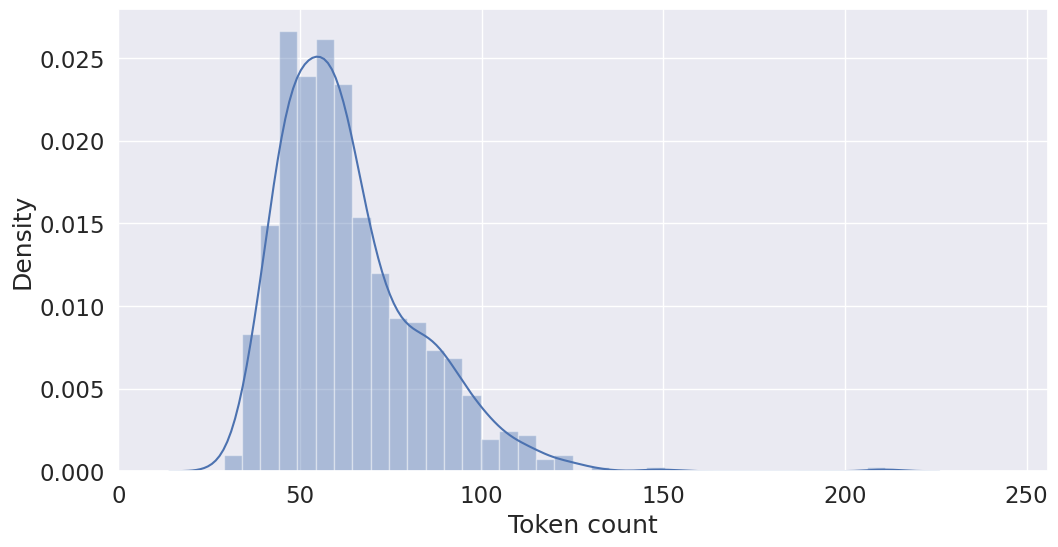

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].extracted_sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    truncation=True,
    padding='longest',
    max_length=256,
    return_tensors='pt'
)

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].extracted_sentence.values,
    add_special_tokens=True,
    truncation=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    return_tensors='pt'
)

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
tags_train = torch.tensor(df[df.data_type=='train']['Tags Mapped'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
tags_val = torch.tensor(df[df.data_type=='val']['Tags Mapped'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, tags_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, tags_val)

In [ ]:
print(len(dataset_train), len(dataset_val))

648 162


In [ ]:
batch_size = 16
dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)
optimizer = AdamW(model.parameters(),lr=8e-7, eps=1e-8)
epochs = 30
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def f1_score_func(preds, tags):
    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()
    return f1_score(tags_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, tags):
    evidence_dict_inverse = {v: k for k, v in evidence_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    tags_flat = tags.flatten()
    for tag in np.unique(tags_flat):
        y_preds = preds_flat[tags_flat==tag]
        y_true = tags_flat[tags_flat==tag]
        print(f'Question Class: {evidence_dict_inverse[tag]}')
        print(f'Accuracy: {len(y_preds[y_preds==tag])}/{len(y_true)}\n')

In [ ]:
seed_val = 123
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model.to(device)
print(device)

cuda


In [ ]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals


In [ ]:
loss_train_avg_list = []
val_loss_list = []
val_f1_list = []

BIO BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
model = BertForSequenceClassification.from_pretrained('dmis-lab/biobert-v1.1', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model.parameters():
    param.data = param.data.contiguous()

# Save the model and tokenizer
model.save_pretrained('./biobert_model')
tokenizer.save_pretrained('./biobert_model')

# Load the tokenizer again from the saved path (if needed)
tokenizer = BertTokenizer.from_pretrained('./biobert_model')

In [ ]:
# Set the model to the correct device
model.to(device)  # Ensure model is on the correct device

# Training loop
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        # Move batch elements to the same device as the model
        batch = tuple(b.to(device) for b in batch)  # Ensure each element in the batch is on the correct device

        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],  # This will now be accepted by BertForSequenceClassification
        }

        # Forward pass
        outputs = model(**inputs)  # Ensure inputs are on the same device

        # Access the loss attribute directly
        loss = outputs.loss
        loss_train_total += loss.item()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimizer step
        optimizer.step()
        scheduler.step()

        # Update progress bar with the training loss
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model after each epoch
    torch.save(model.state_dict(), f'models/finetuned_BioBERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)

    # Validation
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)


  0%|          | 0/3 [00:23<?, ?it/s]


Epoch 1
Training loss: 0.5812352190657359


 33%|███▎      | 1/3 [00:24<00:49, 24.81s/it]

Validation loss: 0.5736349279230292
F1 validation Score (Weighted): 0.6974882928905918



 33%|███▎      | 1/3 [00:48<00:49, 24.81s/it]


Epoch 2
Training loss: 0.5788971156608768


 67%|██████▋   | 2/3 [00:50<00:25, 25.25s/it]

Validation loss: 0.5736349279230292
F1 validation Score (Weighted): 0.6974882928905918



 67%|██████▋   | 2/3 [01:13<00:25, 25.25s/it]


Epoch 3
Training loss: 0.578388339135705


100%|██████████| 3/3 [01:15<00:00, 25.10s/it]

Validation loss: 0.5736349279230292
F1 validation Score (Weighted): 0.6974882928905918


In [ ]:
import os

# List the contents of the models directory
print(os.listdir('models'))


['finetuned_BioBERT_epoch_3.model', 'finetuned_ClinicalBERT_epoch_3.model', 'finetuned_BioBERT_epoch_2.model', 'finetuned_ClinicalBERT_epoch_1.model', 'finetuned_ClinicalBERT_epoch_2.model', 'finetuned_BioBERT_epoch_1.model']


<ipython-input-74-e84cef16dd25>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/finetuned_BioBERT_epoch_3.model', map_location=torc

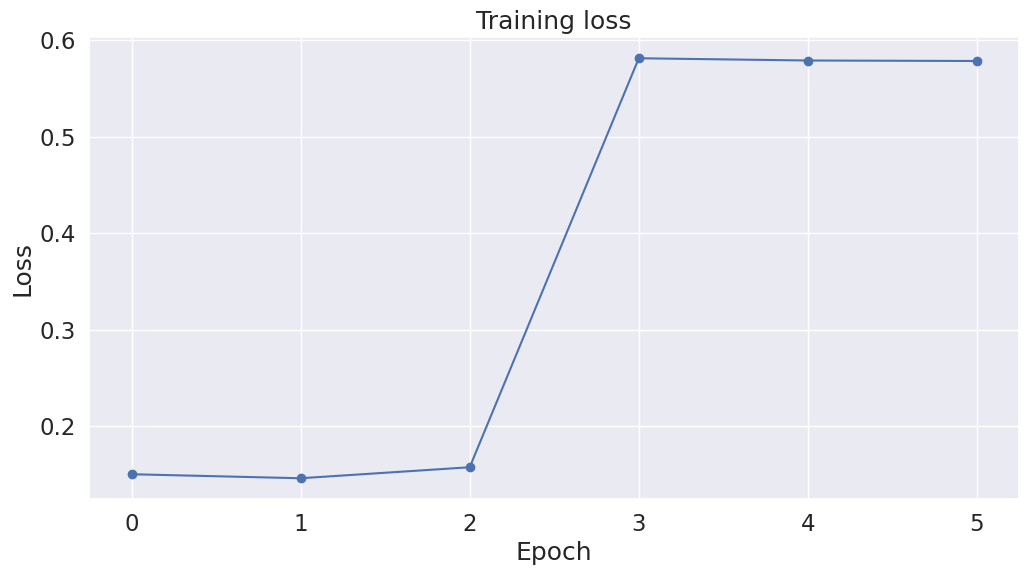

In [ ]:
model.load_state_dict(torch.load('models/finetuned_BioBERT_epoch_3.model', map_location=torch.device('cuda')))
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_train_avg_list, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

PubMedBERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
model = BertForSequenceClassification.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', num_labels=2)  # Change num_labels according to your task

# Move model to device (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for param in model.parameters():
    param.data = param.data.contiguous()

# Create the models directory if it does not exist
if not os.path.exists('models'):
    os.makedirs('models')

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
max_length = 128  # You can adjust the max length
dataset_train = CustomDataset(texts, labels, tokenizer, max_length)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

# Create validation dataset and DataLoader (replace with your validation data)
val_texts = ["Validation text 1", "Validation text 2"]
val_labels = [0, 1]
dataset_validation = CustomDataset(val_texts, val_labels, tokenizer, max_length)
dataloader_validation = DataLoader(dataset_validation, batch_size=16)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 3  # Set the number of epochs
loss_train_avg_list = []
val_loss_list = []
val_f1_list = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in tqdm(range(1, epochs + 1)):
    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to device

        # Forward pass
        outputs = model(**batch)

        loss = outputs.loss  # Access the loss attribute directly
        loss_train_total += loss.item()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimizer step
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model after each epoch
    torch.save(model.state_dict(), f'models/finetuned_PubMedBERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)

    # Evaluate on the validation set
    model.eval()
    val_loss_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader_validation:
            batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to device

            outputs = model(**batch)
            val_loss = outputs.loss
            val_loss_total += val_loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_vals.extend(batch['labels'].cpu().numpy())

    val_loss_avg = val_loss_total / len(dataloader_validation)
    val_f1 = f1_score(true_vals, predictions, average='weighted')

    tqdm.write(f'Validation loss: {val_loss_avg}')
    val_loss_list.append(val_loss_avg)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)


 33%|███▎      | 1/3 [00:20<00:40, 20.11s/it]


Epoch 1
Training loss: 0.5042098611593246
Validation loss: 0.7738233804702759
F1 validation Score (Weighted): 0.3333333333333333



 67%|██████▋   | 2/3 [00:40<00:20, 20.34s/it]


Epoch 2
Training loss: 0.35710489925216227
Validation loss: 0.9213128685951233
F1 validation Score (Weighted): 0.3333333333333333



100%|██████████| 3/3 [01:00<00:00, 20.27s/it]



Epoch 3
Training loss: 0.276991084364115
Validation loss: 0.9837941527366638
F1 validation Score (Weighted): 0.3333333333333333


('./biobert_model/tokenizer_config.json',
 './biobert_model/special_tokens_map.json',
 './biobert_model/vocab.txt',
 './biobert_model/added_tokens.json')

In [ ]:
import os

# List the contents of the models directory
print(os.listdir('models'))


['finetuned_BioBERT_epoch_3.model', 'finetuned_ClinicalBERT_epoch_3.model', 'finetuned_BioBERT_epoch_2.model', 'finetuned_PubMedBERT_epoch_2.model', 'finetuned_PubMedBERT_epoch_3.model', 'finetuned_ClinicalBERT_epoch_1.model', 'finetuned_ClinicalBERT_epoch_2.model', 'finetuned_BioBERT_epoch_1.model', 'finetuned_PubMedBERT_epoch_1.model']


<ipython-input-84-342e280036c4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/finetuned_PubMedBERT_epoch_3.model', map_location=t

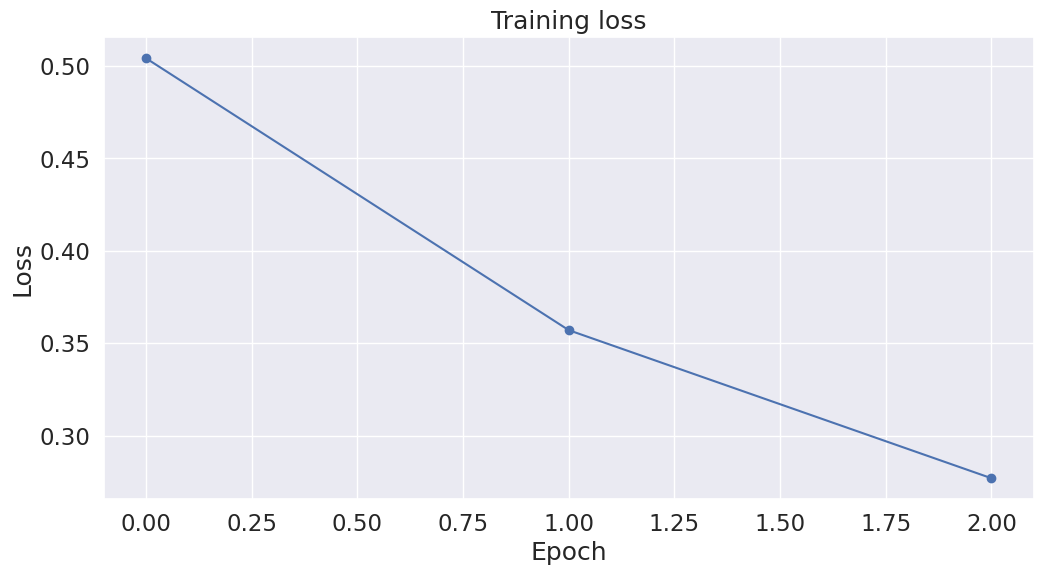

In [ ]:
model.load_state_dict(torch.load('models/finetuned_PubMedBERT_epoch_3.model', map_location=torch.device('cuda')))
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_train_avg_list, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

SciBERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = BertForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=2)  # Change num_labels according to your task

# Move model to device (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
for param in model.parameters():
    param.data = param.data.contiguous()
model.save_pretrained('./scibert_model')
tokenizer.save_pretrained('./scibert_model')


('./scibert_model/tokenizer_config.json',
 './scibert_model/special_tokens_map.json',
 './scibert_model/vocab.txt',
 './scibert_model/added_tokens.json')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('./scibert_model')

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

for epoch in tqdm(range(1, epochs + 1)):
    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to device

        # Forward pass
        outputs = model(**batch)

        loss = outputs.loss  # Access the loss attribute directly
        loss_train_total += loss.item()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Optimizer step
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model after each epoch
    torch.save(model.state_dict(), f'models/finetuned_SciBERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)

    # Evaluate on the validation set
    model.eval()
    val_loss_total = 0
    predictions, true_vals = [], []

    with torch.no_grad():
        for batch in dataloader_validation:
            batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to device

            outputs = model(**batch)
            val_loss = outputs.loss
            val_loss_total += val_loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_vals.extend(batch['labels'].cpu().numpy())

    val_loss_avg = val_loss_total / len(dataloader_validation)
    val_f1 = f1_score(true_vals, predictions, average='weighted')

    tqdm.write(f'Validation loss: {val_loss_avg}')
    val_loss_list.append(val_loss_avg)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)


 33%|███▎      | 1/3 [00:20<00:40, 20.17s/it]


Epoch 1
Training loss: 0.9159266083848243
Validation loss: 0.7030792236328125
F1 validation Score (Weighted): 0.3333333333333333



 67%|██████▋   | 2/3 [00:40<00:20, 20.42s/it]


Epoch 2
Training loss: 0.9117638153188369
Validation loss: 0.7030792236328125
F1 validation Score (Weighted): 0.3333333333333333



100%|██████████| 3/3 [01:00<00:00, 20.31s/it]


Epoch 3
Training loss: 0.8916694463468066
Validation loss: 0.7030792236328125
F1 validation Score (Weighted): 0.3333333333333333


Clinical BERT

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm

data = pd.read_csv("data.csv")  # Update the path to your CSV file

# Check the first few rows
print(data.head())

# Map labels to numerical values
data['label'] = data['Label'].map({'Negative': 0, 'positive': 1})

# Extract texts and labels for training
texts = data['extracted_sentence'].tolist()
labels = data['label'].tolist()
# Tokenization
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Define dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            max_length=512,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            clean_up_tokenization_spaces=False  # Suppress warning
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['extracted_sentence'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# Create DataLoader
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load the model
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(set(data['label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_model(model, train_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            loop.set_description(f'Epoch {epoch + 1}/{epochs}')
            loop.set_postfix(loss=loss.item())

# Train the model
train_model(model, train_loader, optimizer, device, epochs=3)
for param in model.parameters():
    param.data = param.data.contiguous()

# Save the model
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")



       PMID                                 extracted_sentence     Label
0  31399034  However, the functions        of <piRNA>piRNAs...  Negative
1  31399034  In this review, we discuss current findings re...  positive
2  31399034  providing new        insights regarding the po...  positive
3  37407865  In this review, we systematically discuss the ...  positive
4  37407865  AKT pathway regulation, cardiac remodeling and...  positive


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.

('saved_model/tokenizer_config.json',
 'saved_model/special_tokens_map.json',
 'saved_model/vocab.txt',
 'saved_model/added_tokens.json')

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():  # No need to track gradients for evaluation
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()  # Convert to numpy for sklearn
            labels = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = evaluate_model(model, test_loader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Evaluating:   5%|▍         | 1/21 [00:00<00:06,  2.86it/s]Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyword arguments {'clean_up_tokenization_spaces': False} not recognized.
Keyw

Accuracy: 0.8210
Precision: 0.9052
Recall: 0.8537
F1 Score: 0.8787


In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        model.to('cuda')
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    torch.save(model.state_dict(), f'models/finetuned_ClinicalBERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    loss_train_avg_list.append(loss_train_avg)

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 validation Score (Weighted): {val_f1}')
    val_f1_list.append(val_f1)


  0%|          | 0/3 [00:32<?, ?it/s]


Epoch 1
Training loss: 0.16042520467010213


 33%|███▎      | 1/3 [00:33<01:07, 33.81s/it]

Validation loss: 0.2248327901417559
F1 validation Score (Weighted): 0.8989078822412155



 33%|███▎      | 1/3 [01:06<01:07, 33.81s/it]


Epoch 2
Training loss: 0.11732012251528298


 67%|██████▋   | 2/3 [01:07<00:33, 33.77s/it]

Validation loss: 0.23427504152906212
F1 validation Score (Weighted): 0.9058069058069058



 67%|██████▋   | 2/3 [01:33<00:33, 33.77s/it]


Epoch 3
Training loss: 0.08410633950516945


100%|██████████| 3/3 [01:34<00:00, 31.55s/it]

Validation loss: 0.24152477191422472
F1 validation Score (Weighted): 0.9126058169985819
